## Libraries Used

In [295]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns



In [296]:
os.getcwd()

'/Users/karolylajko/Documents/Academy/DataScienceBootcamp2020/Projects/Capstone/HealthCare/data/dataset_diabetes'

In [297]:
os.listdir()

['healthcare.ipynb',
 'Load_Data_Diabetes and Initial EDA copy.ipynb',
 '.DS_Store',
 'before_model_diabdata.csv',
 'IDs_mapping.csv',
 'Richard EDA  copy.ipynb',
 'diabetic_data.csv',
 'before_dummies.csv',
 'healthcare6.ipynb',
 'Diabetes Initial EDA and Feature Engineering copy.ipynb',
 '.ipynb_checkpoints']

## Helper Functions

In [298]:
# Plot Correlation Matrix
def plot_corr_matrix(df, nr_c, targ) :
    
    corr     = df.corr()
    corr_abs = corr.abs()
    cols     = corr_abs.nlargest(nr_c, targ)[targ].index
    cm       = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 12}, 
                yticklabels=cols.values, xticklabels=cols.values,cmap="OrRd")
    plt.show()

# IDC9 codes to diseas 
def idc_to_group (idcnum):
    # Hearth problems
    # External injury and suppl. class - generate 4 digit number - eval to other
    idcnum = idcnum.replace('V','9999').replace('E','9999').replace('?','9999')
    idcnum = float(idcnum) 
    if   390 <= idcnum <= 459 or idcnum == 785:
        diag = 'circulatory'
    # Lung issues
    elif 460 <= idcnum <= 519 or idcnum == 786:
        diag = 'respiratory'
    # Digestive - oral, stomac, abdominal, liver
    elif 520 <= idcnum <= 579 or idcnum == 787:
        diag = 'digestive'
    # Diabetes
    elif int(idcnum) == 250:
        diag = 'diabetis'
    # Injury or poisioning
    elif 800 <= idcnum <= 999:
        diag = 'injury'
    # Musc. system or connective tissue
    elif 710 <= idcnum <= 739:
        diag = 'musculoskeletal'
    # Kidney, urinary and genitals
    elif 580 <= idcnum <= 629 or idcnum == 788:
        diag = 'genitourinary'
    # Abnormal tissue Growth
    elif 140 <= idcnum <= 239 or idcnum in [780,781,782,784,790,791,792,793,794,795,796,797,798,799]:
        diag = 'neoplasms' 
    # Metabolic, immunity issue with no diabetes
    elif (240 <= idcnum <= 279 and idcnum != 250) or (680 <= idcnum <= 790):
        diag = 'neoplasms'
    elif 1 <= idcnum <= 139: 
        diag = 'neoplasms'
     # Other    
    else:
        diag = 'other'   
    return diag

# Convert age range to age average
def age_to_aveage (age):
    ages = ['[0-10)','[10-20)','[20-30)','[30-40)','[40-50)','[50-60)','[60-70)','[70-80)','[80-90)','[90-100)']
    newage = ages.index(age)*10+5
    return newage

# Dummify a categorical variable column
# df - dataframe
# var - variable/feature string
# Prefix for dummies - string
# def makedummies(df,var, pre_fix = 'Class'):
#     Z = pd.get_dummies(df[var], prefix = pre_fix)
#     df_dummified = pd.concat((df.drop(var,1,inplace=True), Z), axis=1)
#     return df_dummified


# Patient either transferred home (healthy) or other care continues
def conv_disch_id(did):
    try: 
        if    did == 1: 
            result = 'home'
        else:
            result = 'other'
        return result
    except ValueError:
        print('Source ID must be interger!')
        
# Convert admission source ID to category groups
def conv_adms_id(sid):
    try: 
        if    sid == 7: 
            result = 'emergency'
        elif  sid == 1:
            result = 'phys_ref'
        elif sid  == 4:
            result = 'hospital'
        elif sid ==  6:
            result = 'snf'
        elif sid ==  2:
            result = 'clin_ref'
        else:
            result = 'other'
        return result
    except ValueError:
        print('Source ID must be interger!')

In [299]:
print('Reading in CSV files')
diabdata = pd.read_csv('diabetic_data.csv')
idmapping = pd.read_csv('IDs_mapping.csv')

Reading in CSV files


In [300]:
diabdata.diag_1.str.contains('V').sum()+ diabdata.diag_1.str.contains('E').sum()

1645

In [301]:
diabdata.shape

(101766, 50)

In [302]:
diabdata.head().transpose().head()

,0,1,2,3,4
encounter_id,2278392,149190,64410,500364,16680
patient_nbr,8222157,55629189,86047875,82442376,42519267
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male
age,[0-10),[10-20),[20-30),[30-40),[40-50)


In [303]:
diabdata[(diabdata['gender']!='Male') & (diabdata['gender']!='Female')]['gender']

30506    Unknown/Invalid
75551    Unknown/Invalid
82573    Unknown/Invalid
Name: gender, dtype: object

In [304]:
# Generating the indexes for the numerical and categorical variables
categorical_idx = diabdata.dtypes[diabdata.dtypes=='object'].index
numerical_idx   = diabdata.dtypes[diabdata.dtypes!='object'].index

In [305]:
print('The unique number of patients, keep only these rows? ')
diabdata.patient_nbr.value_counts().count()

The unique number of patients, keep only these rows? 


71518

In [306]:
print('The number of unique patient ids')
diabdata.drop_duplicates(subset= ['patient_nbr'], keep = 'first')['patient_nbr'].count()

The number of unique patient ids


71518

## Feature Overview

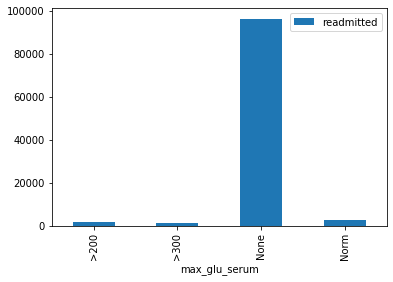

In [307]:
diabdata[['max_glu_serum','readmitted']].groupby(['max_glu_serum']).count().plot.bar()

In [308]:
diabdata['max_glu_serum'].value_counts()

None    96420
Norm     2597
>200     1485
>300     1264
Name: max_glu_serum, dtype: int64

In [309]:
diabdata.groupby(['A1Cresult','readmitted'])['A1Cresult','readmitted'].count()

A1Cresult  readmitted
A1Cresult readmitted                       
>7        <30               383         383
          >30              1300        1300
          NO               2129        2129
>8        <30               811         811
          >30              2901        2901
          NO               4504        4504
None      <30              9681        9681
          >30             29745       29745
          NO              45322       45322
Norm      <30               482         482
          >30              1599        1599
          NO               2909        2909

In [310]:
idmapping.shape

(67, 2)

In [311]:
idmapping.transpose().head()

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
admission_type_id,1,2,3,4,5,6,7,8,NaN,discharge_disposition_id,...,17,18,19,20,21,22,23,24,25,26
description,Emergency,Urgent,Elective,Newborn,Not Available,NaN,Trauma Center,Not Mapped,NaN,description,...,NaN,Transfer From Another Home Health Agency,Readmission to Same Home Health Agency,Not Mapped,Unknown/Invalid,Transfer from hospital inpt/same fac reslt in...,Born inside this hospital,Born outside this hospital,Transfer from Ambulatory Surgery Center,Transfer from Hospice


## Jae Features

In [312]:
# my_columns = '''encounter_id, patient_nbr, admission_type_id, 
# discharge_disposition_id, admission_source_id, time_in_hospital, 
# num_lab_procedures, num_procedures, num_medications, number_outpatient, 
# number_emergency, number_inpatient, number_diagnoses, readmitted
# '''
# my_columns = my_columns.split(',')
# my_columns = [s.strip() for s in my_columns]
# my_columns
# set(my_columns) - set(diabdata.columns.tolist())

In [313]:
# myDF = diabdata[my_columns]
# myDF

In [314]:
# myDF.isna().sum()

In [315]:
print('Dischage Reasons: ')

diabdata.discharge_disposition_id.value_counts()[:10]

Dischage Reasons: 


1     60234
3     13954
6     12902
18     3691
2      2128
22     1993
11     1642
5      1184
25      989
4       815
Name: discharge_disposition_id, dtype: int64

### ID Fileds
- The ID fields are integers but they are codes that need to be decoded and grouped into categories. Need one hot encoding after. 

admission_type_id: 

 1: 'Emergency',
 2: 'Urgent',
 3: 'Elective',
 4: 'Newborn',
 5: 'Not Available',
 6: nan,
 7: 'Trauma Center',
 8: 'Not Mapped'

discharge_disposition_id:

1: Discharged to Home
2: Another Hospital
3: Transferred a Skilled Nurse Fascility (SNF)
4: Transferred a Intensive Care Fasc. (ICF)
5: Transferred a Impatient Care Inst.
6: Transferred to Home with Home Health
11: Expired/Death
18: NULL
25: Not Mapped

admission_source_id:

1: Physician Referral
2: Clinic Referral
3: HMO Referral
4: Transfer from a hospital
5: Transfer from a Skilled Nursing Facility (SNF)
6: Transfer from another health care facility
7: Emergency Room
9: Not Available
17: NULL
20: Not Mapped



In [316]:
diabdata.discharge_disposition_id.value_counts()[:10]

1     60234
3     13954
6     12902
18     3691
2      2128
22     1993
11     1642
5      1184
25      989
4       815
Name: discharge_disposition_id, dtype: int64

In [317]:
diabdata.admission_source_id.apply(lambda x: conv_adms_id(x))

0          phys_ref
1         emergency
2         emergency
3         emergency
4         emergency
            ...    
101761    emergency
101762        other
101763    emergency
101764    emergency
101765    emergency
Name: admission_source_id, Length: 101766, dtype: object

In [318]:
# Check if function works, non-mutating
diabdata.discharge_disposition_id.apply(lambda x: conv_disch_id(x))

0         other
1          home
2          home
3          home
4          home
          ...  
101761    other
101762    other
101763     home
101764    other
101765     home
Name: discharge_disposition_id, Length: 101766, dtype: object

In [319]:
# To map dictionary values to panda df columns keys set 1 -to - ID
def fix_dict_keys(mydict):
    j = 1
    temp_dict={}
    for key in mydict: 
        temp_dict[j] = mydict[key]
        j+=1
    return temp_dict
# --------------------------------------------------
# Extract the ID information from mapping data frame

# admission_type_id
ad_type_id_dict    = idmapping.iloc[0:8,]['description'].to_dict()

# discharge_disposition_id
discharge_id_dict  = idmapping.iloc[10:41,]['description'].to_dict()

# admission_source_id
adm_source_id_dict = idmapping.iloc[43:,]['description'].to_dict()

map_adm_type     = fix_dict_keys(ad_type_id_dict)
map_disch_type   = fix_dict_keys(discharge_id_dict)
map_source_type  = fix_dict_keys(adm_source_id_dict)

map_adm_type

{1: 'Emergency',
 2: 'Urgent',
 3: 'Elective',
 4: 'Newborn',
 5: 'Not Available',
 6: nan,
 7: 'Trauma Center',
 8: 'Not Mapped'}

## Univariate Data analysis
- Analyzing the features induvidually

In [320]:
print('The target Variable Classes')
diabdata.readmitted.value_counts()

The target Variable Classes


NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [321]:
diabdata.diabetesMed.value_counts()

Yes    78363
No     23403
Name: diabetesMed, dtype: int64

In [322]:
# Value distribution of categorical Variables

# for col in diabdata.columns.tolist():
#     print(diabdata[col].value_counts())

In [323]:
diabdata.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [324]:
print('Numerous categorical features')
# diabdata.dtypes

Numerous categorical features


In [325]:
print('The different types of data in the dataset: \n',diabdata.dtypes.value_counts())


The different types of data in the dataset: 
 object    37
int64     13
dtype: int64


Text(0.5, 1.0, 'TimeInH0spital VS. Readmission')

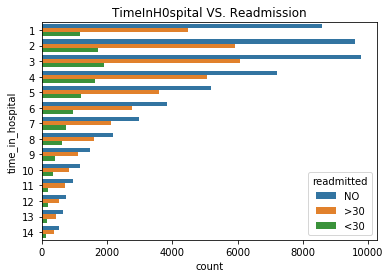

In [326]:
sns.countplot(y= diabdata['time_in_hospital'], hue = diabdata['readmitted']).set_title('TimeInH0spital VS. Readmission')

In [327]:
diabdata.groupby(['A1Cresult','readmitted'])['A1Cresult','readmitted'].count()

A1Cresult  readmitted
A1Cresult readmitted                       
>7        <30               383         383
          >30              1300        1300
          NO               2129        2129
>8        <30               811         811
          >30              2901        2901
          NO               4504        4504
None      <30              9681        9681
          >30             29745       29745
          NO              45322       45322
Norm      <30               482         482
          >30              1599        1599
          NO               2909        2909

Text(0.5, 1.0, 'NumOfProcedures VS. Readmission')

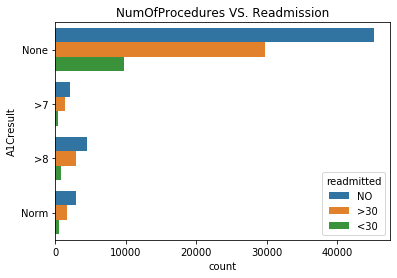

In [328]:
sns.countplot(y= diabdata['A1Cresult'], hue = diabdata['readmitted']).set_title('NumOfProcedures VS. Readmission')

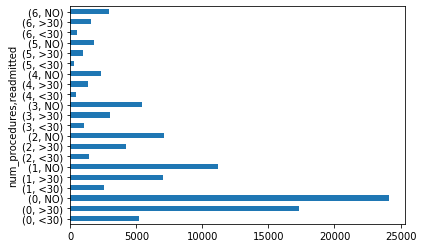

In [329]:
print()
diabdata.groupby(['num_procedures','readmitted'])['readmitted'].count().plot.barh()

Text(0.5, 1.0, 'NumOfProcedures VS. Readmission')

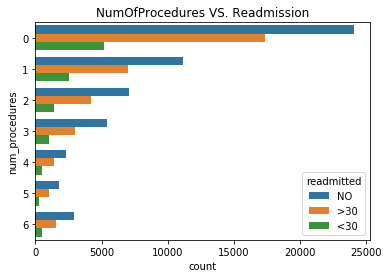

In [330]:
sns.countplot(y= diabdata['num_procedures'], hue = diabdata['readmitted']).set_title('NumOfProcedures VS. Readmission')

In [331]:
diabdata.groupby(['num_medications','readmitted'])[['readmitted']].count()[:20].T

num_medications   1            2             3              4              5  \
readmitted      <30 >30   NO <30  >30   NO <30  >30   NO  <30  >30   NO  <30   
readmitted       11  72  179  39  106  325  65  209  626  114  381  922  150   

num_medications               6               7        
readmitted       >30    NO  <30  >30    NO  <30   >30  
readmitted       537  1330  229  789  1681  305  1066

## Data Cleaning
- Missing Values
- Outliers


In [332]:
# print('The unique number of patients, keep only these rows? ')
# diabdata.patient_nbr.value_counts().count()

# diabdata = diabdata.drop_duplicates(subset= ['patient_nbr'], keep = 'first') 

In [333]:
diabdata.shape

(101766, 50)

In [334]:
# Filtering rows by dropping fields with quesiton mark '?'
# diag codes
drop_Idx = set()
drop_Idx = drop_Idx.union(set(diabdata[diabdata['diag_1']                   == '?'].index)) # Unknown
drop_Idx = drop_Idx.union(set(diabdata[diabdata['diag_2']                   == '?'].index)) # Unknown
drop_Idx = drop_Idx.union(set(diabdata[diabdata['diag_3']                   == '?'].index)) # Unknown
drop_Idx = drop_Idx.union(set(diabdata[diabdata['discharge_disposition_id'] == 11].index))  # Death
drop_Idx = drop_Idx.union(set(diabdata[diabdata['gender']                   == 'Unknown/Invalid'].index))

new_Idx = list(set(diabdata.index) - set(drop_Idx))
diabdata = diabdata.iloc[new_Idx]

In [335]:
# diabdata[diabdata['diag_1']=='?']

In [336]:
diabdata.shape

(98601, 50)

In [337]:
# diabdata = diabdata[~(diabdata == '?').any(axis=1)]
# diabdata[~(diabdata == '?').any(axis=1)]

In [338]:
print('Missing Values per feature')
print('Top 10 variables of missing values')
diabdata.isnull().sum().sort_values(ascending=False)[:10]

Missing Values per feature
Top 10 variables of missing values


readmitted            0
num_lab_procedures    0
max_glu_serum         0
number_diagnoses      0
diag_3                0
diag_2                0
diag_1                0
number_inpatient      0
number_emergency      0
number_outpatient     0
dtype: int64

In [339]:
np.sum(diabdata.age.isnull())

0

In [340]:
diabdata[diabdata['gender']=='Unknown/Invalid']['gender']

Series([], Name: gender, dtype: object)

Text(0.5, 1.0, 'Age of Patient VS. Readmission')

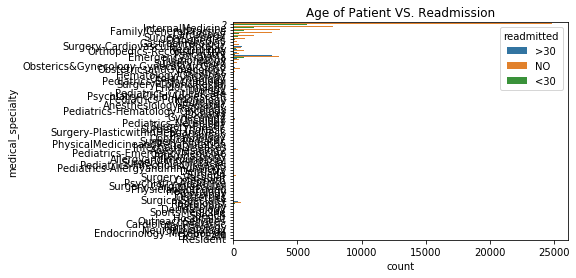

In [341]:
sns.countplot(y= diabdata['medical_specialty'], hue = diabdata['readmitted']).set_title('Age of Patient VS. Readmission')

Text(0.5, 1.0, 'Age of Patient VS. Readmission')

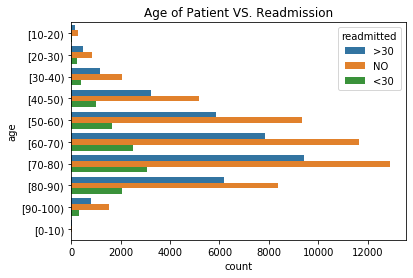

In [342]:
sns.countplot(y= diabdata['age'], hue = diabdata['readmitted']).set_title('Age of Patient VS. Readmission')

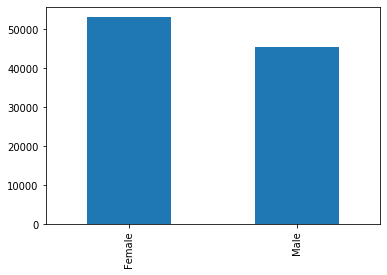

In [343]:
diabdata.gender.value_counts().plot.bar()

In [344]:
# sns.countplot(y= diabdata['diag_2_temp'], hue = diabdata['readmitted']).set_title('Primary Diag. VS. Readmission')

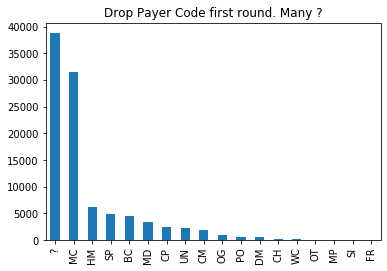

In [345]:
diabdata.payer_code.value_counts().plot.bar(title ='Drop Payer Code first round. Many ?')

In [346]:
diabdata.diag_1.value_counts()[:10]

428    6727
414    6519
786    3977
410    3474
486    3401
427    2718
491    2234
715    2119
682    2000
780    1997
Name: diag_1, dtype: int64

In [347]:
diagnosis = diabdata.loc[diabdata['readmitted']=='<30',['readmitted','diag_1','diag_2','diag_3']]
# percent_miss_count = (dftrain.isnull().sum()/dftrain.isnull().count()).sort_values(ascending=False)
#['diag_1','diag_2','diag_3']
# pd.concat([tot_miss_count,percent_miss_count], axis =1,keys=['NA_count','NA_percent'])[:20]

print
diagnosis.groupby('diag_1').count().sort_values('readmitted',ascending=False)[:30]['readmitted'].sum()


6899

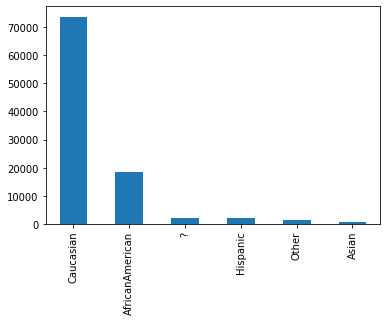

In [348]:
diabdata.race.value_counts().plot.bar()

In [349]:
# Getting rid of the Unknowns for Gender - not real significance
diabdata.gender = diabdata.gender.replace('Unknown/Invalid','Female')
diabdata.gender.value_counts()

Female    53081
Male      45520
Name: gender, dtype: int64

In [350]:
diabdata.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,...,No,Steady,No,No,No,No,No,No,Yes,>30


In [351]:
# Take care of the race missing values and minority asian as outlier
diabdata.race = diabdata.race.replace('?','Missing').replace('Asian','Other').replace('Hispanic','Other')
diabdata.race.value_counts()

Caucasian          73835
AfricanAmerican    18560
Other               4051
Missing             2155
Name: race, dtype: int64

In [352]:
# Following guideline filling in missing for '?'
diabdata.medical_specialty  = diabdata.medical_specialty.replace('?','Missing')

In [353]:
# Convert the discharge ID codes to group of classes 
diabdata.discharge_disposition_id = diabdata.discharge_disposition_id.apply(lambda x: conv_disch_id(x))

In [354]:
# Convert the admission source ID codes to group of classes 
diabdata.admission_source_id = diabdata.admission_source_id.apply(lambda x: conv_adms_id(x))

## Feature Engineering
- Grouping values within feature: IDC code (based on first 3 characters)
- One hot encoding
- Dummification

In [355]:
# Converting IDC9 iagnostic codes  to characters

diags = ['diag_1','diag_2','diag_3']
for diag in diags:
    diagt = str(diag + '_temp')
    diabdata[diagt] = diabdata[diag].apply(lambda x : idc_to_group(x))

Text(0.5, 1.0, 'Primary Diagnosis')

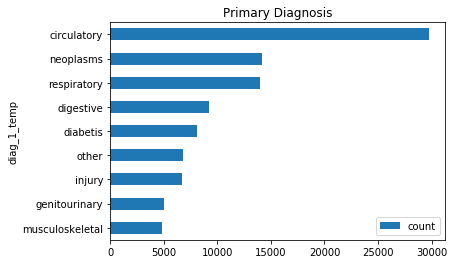

In [356]:
diabdata.groupby('diag_1_temp').agg({'diag_1':['count']})['diag_1'].sort_values('count').plot.barh() 
#,ascending=False
plt.title('Primary Diagnosis')

Text(0.5, 1.0, 'Primary Diag. VS. Readmission')

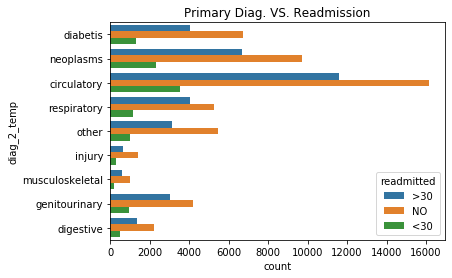

In [357]:
sns.countplot(y= diabdata['diag_2_temp'], hue = diabdata['readmitted']).set_title('Primary Diag. VS. Readmission')

Text(0.5, 1.0, 'Secondary Diagnosis')

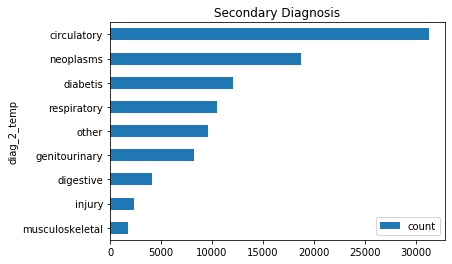

In [358]:
diabdata.groupby('diag_2_temp').agg({'diag_2':['count']})['diag_2'].sort_values('count').plot.barh()
plt.title('Secondary Diagnosis')

Text(0.5, 1.0, 'Third Diagnosis')

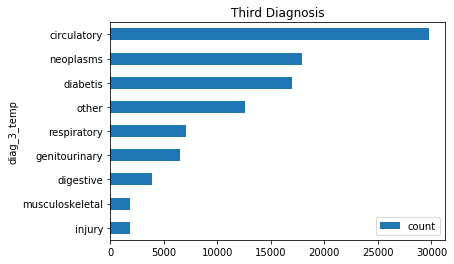

In [359]:
diabdata.groupby('diag_3_temp').agg({'diag_3':['count']})['diag_3'].sort_values('count').plot.barh()
plt.title('Third Diagnosis')

In [360]:
diabdata.diag_1.str.contains('V').sum()+ diabdata.diag_1.str.contains('E').sum()

1632

In [361]:
# fig = plt.figure(figsize=(15, 9))
# sns.boxplot(y=diabdata.readmitted, x=diabdata.newage)
# plt.show()

In [362]:
# Transform the target variable to those admitted before 30 days and others
diabdata.readmitted = diabdata.readmitted.apply(lambda x : 1 if x =='<30' else 0)

In [363]:
# Convert age range to ages
diabdata['newage'] = diabdata['age'].apply(lambda x: age_to_aveage(x) )
diabdata.newage.value_counts()

75    25394
65    21992
55    16891
85    16602
45     9415
35     3606
95     2661
25     1508
15      468
5        64
Name: newage, dtype: int64

In [364]:
diabdata.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,diag_1_temp,diag_2_temp,diag_3_temp,newage
1,149190,55629189,Caucasian,Female,[10-20),?,1,home,emergency,3,...,No,No,No,Ch,Yes,0,neoplasms,diabetis,neoplasms,15
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,home,emergency,2,...,No,No,No,No,Yes,0,other,diabetis,other,25
3,500364,82442376,Caucasian,Male,[30-40),?,1,home,emergency,2,...,No,No,No,Ch,Yes,0,neoplasms,diabetis,circulatory,35
4,16680,42519267,Caucasian,Male,[40-50),?,1,home,emergency,1,...,No,No,No,Ch,Yes,0,neoplasms,neoplasms,diabetis,45
5,35754,82637451,Caucasian,Male,[50-60),?,2,home,clin_ref,3,...,No,No,No,No,Yes,0,circulatory,circulatory,diabetis,55


## Removing multiple visit for each patient that is indicated by patient_nbr
This ensures that observations are independent

In [365]:
print('The unique number of patients, keep only these rows? ')
diabdata.patient_nbr.value_counts().count()

diabdata = diabdata.drop_duplicates(subset= ['patient_nbr'], keep = 'first') 

The unique number of patients, keep only these rows? 


In [366]:
diabdata.shape

(69340, 54)

## Dropping Feature Columns

- patient_nbr: 
- encounter_id:
- payer_code: 
- max_glu_serum: 
- weight: Too many missing value
-
-


In [367]:
# Drop columns that are not needed

# cols_to_drop = ['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
#        'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
#        'time_in_hospital', 'payer_code', 'medical_specialty',
#        'num_lab_procedures', 'num_procedures', 'num_medications',
#        'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
#        'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
#        'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
#        'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
#        'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
#        'tolazamide', 'examide', 'citoglipton', 'insulin',
#        'glyburide-metformin', 'glipizide-metformin',
#        'glimepiride-pioglitazone', 'metformin-rosiglitazone',
#        'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
#        'newage']
cols_to_drop = ['encounter_id', 'patient_nbr', 'age', 'weight', 'admission_type_id',
                'payer_code', 'medical_specialty',
                'num_lab_procedures', 'num_procedures', 
                'number_outpatient', 'number_emergency', 'number_inpatient', 
                'number_diagnoses', 'max_glu_serum',
                'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone','diag_1','diag_2','diag_3',
                'diag_2_temp','diag_3_temp']

# second round: include: num_medications, 

diabdata.drop(cols_to_drop, inplace= True, axis = 1)



In [368]:
diabdata.head()

,race,gender,discharge_disposition_id,admission_source_id,time_in_hospital,num_medications,A1Cresult,change,diabetesMed,readmitted,diag_1_temp,newage
1,Caucasian,Female,home,emergency,3,18,None,Ch,Yes,0,neoplasms,15
2,AfricanAmerican,Female,home,emergency,2,13,None,No,Yes,0,other,25
3,Caucasian,Male,home,emergency,2,16,None,Ch,Yes,0,neoplasms,35
4,Caucasian,Male,home,emergency,1,8,None,Ch,Yes,0,neoplasms,45
5,Caucasian,Male,home,clin_ref,3,16,None,No,Yes,0,circulatory,55


In [369]:
# Save data before modification dummification
diabdata.to_csv('before_dummies.csv')

## One Hot Encoing of categorical features

In [370]:
diabdata2 = pd.read_csv('before_dummies.csv',index_col=0)
diabdata2.columns

Index(['race', 'gender', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_medications', 'A1Cresult', 'change',
       'diabetesMed', 'readmitted', 'diag_1_temp', 'newage'],
      dtype='object')

In [371]:
prefix = 'class1'
step1 = pd.get_dummies(diabdata2['diag_1_temp'], prefix = 'class1')

diabdata2 = pd.concat([diabdata2,step1], axis=1)
diabdata2.drop('diag_1_temp',1,inplace=True)
diabdata2.drop(str(prefix+'_'+'diabetis'),axis=1,inplace=True)

In [372]:
diabdata2.shape

(69340, 19)

In [373]:
print(diabdata2.shape)
diabdata2.head()

(69340, 19)


,race,gender,discharge_disposition_id,admission_source_id,time_in_hospital,num_medications,A1Cresult,change,diabetesMed,readmitted,newage,class1_circulatory,class1_digestive,class1_genitourinary,class1_injury,class1_musculoskeletal,class1_neoplasms,class1_other,class1_respiratory
1,Caucasian,Female,home,emergency,3,18,None,Ch,Yes,0,15,0,0,0,0,0,1,0,0
2,AfricanAmerican,Female,home,emergency,2,13,None,No,Yes,0,25,0,0,0,0,0,0,1,0
3,Caucasian,Male,home,emergency,2,16,None,Ch,Yes,0,35,0,0,0,0,0,1,0,0
4,Caucasian,Male,home,emergency,1,8,None,Ch,Yes,0,45,0,0,0,0,0,1,0,0
5,Caucasian,Male,home,clin_ref,3,16,None,No,Yes,0,55,1,0,0,0,0,0,0,0


In [374]:
# prefix = 'class2'
# step2 = pd.get_dummies(diabdata2['gender'], prefix = 'class2')

# diabdata2 = pd.concat([diabdata2,step2], axis=1)
diabdata2.drop('gender',1,inplace=True)
# diabdata2.drop(str(prefix+'_'+'Male'),axis=1,inplace=True)
# diabdata2.shape

In [375]:
prefix = 'class3'
step3 = pd.get_dummies(diabdata2['race'], prefix = 'class3')# drop_first=True

diabdata2 = pd.concat([diabdata2,step3], axis=1)
diabdata2.drop('race',1,inplace=True)
diabdata2.drop(str(prefix+'_'+'AfricanAmerican'),axis=1,inplace=True)
diabdata2.shape

(69340, 20)

In [376]:
# prefix = 'class4'
# step4 = pd.get_dummies(diabdata2['change'], prefix = 'class4')

# diabdata2 = pd.concat([diabdata2,step4], axis=1)
diabdata2.drop('change',1,inplace=True)
# diabdata2.drop(str(prefix+'_'+'Male'),axis=1,inplace=True)
# diabdata2.shape

In [377]:
# prefix = 'class5'
# step5 = pd.get_dummies(diabdata2['diabetesMed'], prefix = 'class5')

# diabdata2 = pd.concat([diabdata2,step5], axis=1)
diabdata2.drop('diabetesMed',1,inplace=True)
# diabdata2.drop(str(prefix+'_'+'Male'),axis=1,inplace=True)
# diabdata2.shape

In [378]:
diabdata2.head()

,discharge_disposition_id,admission_source_id,time_in_hospital,num_medications,A1Cresult,readmitted,newage,class1_circulatory,class1_digestive,class1_genitourinary,class1_injury,class1_musculoskeletal,class1_neoplasms,class1_other,class1_respiratory,class3_Caucasian,class3_Missing,class3_Other
1,home,emergency,3,18,None,0,15,0,0,0,0,0,1,0,0,1,0,0
2,home,emergency,2,13,None,0,25,0,0,0,0,0,0,1,0,0,0,0
3,home,emergency,2,16,None,0,35,0,0,0,0,0,1,0,0,1,0,0
4,home,emergency,1,8,None,0,45,0,0,0,0,0,1,0,0,1,0,0
5,home,clin_ref,3,16,None,0,55,1,0,0,0,0,0,0,0,1,0,0


In [379]:
prefix = 'class6'
step6 = pd.get_dummies(diabdata2['discharge_disposition_id'], prefix = 'class6')

diabdata2 = pd.concat([diabdata2,step6], axis=1)
diabdata2.drop('discharge_disposition_id',1,inplace=True)
diabdata2.drop(str(prefix+'_'+'home'),axis=1,inplace=True)
diabdata2.shape

(69340, 18)

In [380]:
prefix = 'class7'
step7 = pd.get_dummies(diabdata2['admission_source_id'], prefix = 'class7')

diabdata2 = pd.concat([diabdata2,step7], axis=1)
diabdata2.drop('admission_source_id',1,inplace=True)
diabdata2.drop(str(prefix+'_'+'emergency'),axis=1,inplace=True)
diabdata2.shape

(69340, 22)

In [381]:
prefix = 'class8'
step8 = pd.get_dummies(diabdata2['A1Cresult'], prefix = 'class8')

diabdata2 = pd.concat([diabdata2,step8], axis=1)
diabdata2.drop('A1Cresult',1,inplace=True)
diabdata2.drop(str(prefix+'_'+'None'),axis=1,inplace=True)
diabdata2.shape

(69340, 24)

In [382]:
diabdata2.columns.to_list()

['time_in_hospital',
 'num_medications',
 'readmitted',
 'newage',
 'class1_circulatory',
 'class1_digestive',
 'class1_genitourinary',
 'class1_injury',
 'class1_musculoskeletal',
 'class1_neoplasms',
 'class1_other',
 'class1_respiratory',
 'class3_Caucasian',
 'class3_Missing',
 'class3_Other',
 'class6_other',
 'class7_clin_ref',
 'class7_hospital',
 'class7_other',
 'class7_phys_ref',
 'class7_snf',
 'class8_>7',
 'class8_>8',
 'class8_Norm']

In [383]:
diabdata2.to_csv('before_model_diabdata.csv')

## Logistic Regression Model 

In [443]:
diabdata3 = pd.read_csv('before_model_diabdata.csv',index_col=0)
diabdata3.columns

Index(['time_in_hospital', 'num_medications', 'readmitted', 'newage',
       'class1_circulatory', 'class1_digestive', 'class1_genitourinary',
       'class1_injury', 'class1_musculoskeletal', 'class1_neoplasms',
       'class1_other', 'class1_respiratory', 'class3_Caucasian',
       'class3_Missing', 'class3_Other', 'class6_other', 'class7_clin_ref',
       'class7_hospital', 'class7_other', 'class7_phys_ref', 'class7_snf',
       'class8_>7', 'class8_>8', 'class8_Norm'],
      dtype='object')

In [444]:

from sklearn.linear_model    import LogisticRegression, SGDClassifier
from sklearn.metrics         import accuracy_score, f1_score, recall_score
from sklearn.metrics         import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn                 import datasets
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, train_test_split


### Standardize Data 
- Only if needed
- Standardize features by removing the mean and scaling to unit variance

- The standard score of a sample x is calculated as:

- *z = (x - u) / s*

In [445]:
# # Create the standardized version of the datasets

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# scaler.fit(diabdata3.drop('readmitted',1))
# X_train_scaled = scaler.transform(diabdata3.drop('readmitted',1))
# y_train_scaled = scaler.transform(diabdata3.drop('readmitted',1))
# # # dftrain_y_scaled = scaler.transform(dftrain['SalePrice']) # not needed?
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range = (0,1))

# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test  = scaler.transform(X_test)

### Create Train and Test data
- To avoid overfitting it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set X_test, y_test.

- Split the ***diabetes*** dataset into random train and test subsets
- There is option to stratify by setting 

In [446]:

X = diabdata3.drop('readmitted',1)
y = diabdata3.readmitted

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=42)

(69340, 23) (69340,)


## Cross Validation

In [447]:



# First Run
diabetes_model = LogisticRegression(solver='liblinear',class_weight='balanced')
diabetes_model.fit(X_train,y_train)

# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

scores = cross_val_score(diabetes_model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.601


In [470]:
y_pred = diabetes_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.63      0.75     18905
           1       0.12      0.52      0.20      1897

    accuracy                           0.62     20802
   macro avg       0.53      0.57      0.47     20802
weighted avg       0.86      0.62      0.70     20802



## Grid Search - Hyperparameters

In [448]:

# Create regularization hyperparameter space
grid_params={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

grid_log = LogisticRegression(solver='liblinear')
gridsearch_logit = GridSearchCV(grid_log, grid_params, cv = 5)
gridsearch_logit.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [449]:
print('Gridsearch Object Best Score: ',gridsearch_logit.best_params_)

Gridsearch Object Best Score:  {'C': 0.001, 'penalty': 'l1'}


In [450]:
coefdf = pd.DataFrame(diabetes_model.coef_)
coefdf.columns = diabdata3.drop('readmitted',axis=1).columns.tolist()
coefdf = coefdf.transpose() #.columns = ['Coefficients']
coefdf.columns = ['Coefficients']


Text(0.5, 0, 'Magnitude')

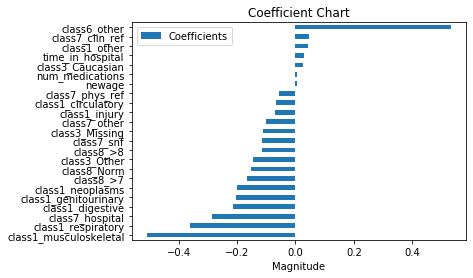

In [451]:
coefdf.sort_values('Coefficients').plot.barh()
plt.title('Coefficient Chart')
plt.xlabel('Magnitude')

In [452]:
diab_logit.classes_

array([0, 1])

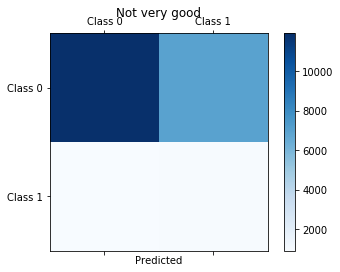

In [453]:

conf_matrix = confusion_matrix(y_test, y_pred)
labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax  = fig.add_subplot(111)
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)

fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
# plt.ylabel('True Values')
plt.xlabel('Predicted')
plt.title('Not very good')
plt.show()

In [454]:

confusion_matrix(y_test, y_pred)

array([[11909,  6996],
       [  914,   983]])

In [455]:
y_pred       = diab_logit.predict(X_test)
y_pred_proba = diab_logit.predict_proba(X_test)

In [456]:
pd.Series(y_test).index = pd.Series(y_pred).index

In [457]:
predictions = pd.concat([pd.Series(y_test),pd.Series(y_pred),pd.DataFrame(y_pred_proba)],axis=1)
predictions.columns = ['readmitted','predicted','prob_not_readmitted','prob_readmitted']

In [458]:
predictions['pred_55p']= predictions.prob_readmitted.map(lambda x : 1 if x > 0.55 else 0 )
predictions['pred_50p']= predictions.prob_readmitted.map(lambda x : 1 if x > 0.50 else 0 )
predictions['pred_45p']= predictions.prob_readmitted.map(lambda x : 1 if x > 0.45 else 0 )
predictions['pred_40p']= predictions.prob_readmitted.map(lambda x : 1 if x > 0.40 else 0 )
predictions['pred_35p']= predictions.prob_readmitted.map(lambda x : 1 if x > 0.35 else 0 )
predictions['pred_30p']= predictions.prob_readmitted.map(lambda x : 1 if x > 0.30 else 0 )
predictions

,readmitted,predicted,prob_not_readmitted,prob_readmitted,pred_55p,pred_50p,pred_45p,pred_40p,pred_35p,pred_30p
0,0,0,0.523482,0.476518,0,0,1,1,1,1
1,0,0,0.646526,0.353474,0,0,0,0,1,1
2,0,1,0.378530,0.621470,1,1,1,1,1,1
3,0,1,0.495628,0.504372,0,1,1,1,1,1
4,0,1,0.443385,0.556615,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
20797,0,0,0.512239,0.487761,0,0,1,1,1,1
20798,0,0,0.563120,0.436880,0,0,0,1,1,1
20799,0,0,0.637850,0.362150,0,0,0,0,1,1
20800,0,0,0.650350,0.349650,0,0,0,0,0,1


In [459]:
mat_list = ['pred_30p','pred_35p','pred_40p','pred_45p','pred_50p','pred_55p']

[print(confusion_matrix(predictions.readmitted,predictions[pred] )) for pred in mat_list]


[[   45 18860]
 [    1  1896]]
[[  731 18174]
 [   38  1859]]
[[ 3251 15654]
 [  195  1702]]
[[ 8198 10707]
 [  565  1332]]
[[11909  6996]
 [  914   983]]
[[13642  5263]
 [ 1115   782]]


[None, None, None, None, None, None]

## Decile Analysis
- Decile analysis is created to test the model’s ability to predict the intended outcome.
- A range should be observed from most likely to least likely prediction 

In [433]:

prange,bins = pd.qcut(predictions['prob_readmitted'],10,retbins=True)

bins[0]  -= 0.001
bins[-1] += 0.001

bins_labels = ['%d.(%0.2f,%0.2f]'%(x[0],x[1][0],x[1][1]) for x in enumerate(zip(bins[:-1],bins[1:]))]
bins_labels[0]                 = bins_labels[0].replace('(','[')

predictions['Decile']          = pd.cut(predictions['prob_readmitted'],bins=bins,labels=bins_labels)
predictions['Patients']        = 1
predictions['Not_Readmitted']  = 1-predictions['readmitted']
predictions['Readmitted']      =   predictions['readmitted']
predictions['Prob_Min']        = prange.apply(lambda x : x.left)
predictions['Prob_Max']        = prange.apply(lambda x : x.right)
    
summary  = predictions.groupby(['Decile'])[['Readmitted','Not_Readmitted','Patients','Prob_Min','Prob_Max']].sum()
# summary['Prob_MinMax'] = ['%0.2f - %0.2f'%(x[1][0],x[1][1]) for x in enumerate(zip(bins[:-1],bins[1:]))]
summary['Prob_Min']    = [x for x in bins[:-1]]
summary['Prob_Max']    = [x for x in bins[1: ]]

summary  = summary.sort_index(ascending=False)

    
summary['ReadmittedRate_pct']  =summary['Readmitted']/summary['Patients']
summary['Lift'] = (summary['Readmitted']/summary['Patients'])/.10
summary

[Text(0, 0, '0.[0.24,0.38]'),
 Text(0, 0, '1.(0.38,0.41]'),
 Text(0, 0, '2.(0.41,0.43]'),
 Text(0, 0, '3.(0.43,0.45]'),
 Text(0, 0, '4.(0.45,0.47]'),
 Text(0, 0, '5.(0.47,0.49]'),
 Text(0, 0, '6.(0.49,0.55]'),
 Text(0, 0, '7.(0.55,0.59]'),
 Text(0, 0, '8.(0.59,0.62]'),
 Text(0, 0, '9.(0.62,0.73]')]

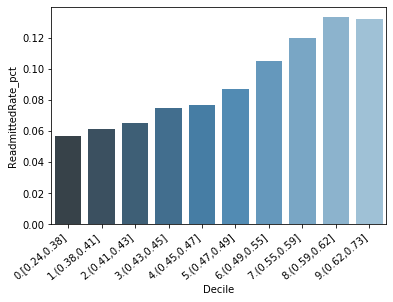

In [436]:
ax = sns.barplot(x=summary.index, y=summary.ReadmittedRate_pct, data=summary,palette="Blues_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


In [437]:
summary.Prob_Min[0]

0.2435581256240251

[Text(0, 0, '0.[0.24,0.38]'),
 Text(0, 0, '1.(0.38,0.41]'),
 Text(0, 0, '2.(0.41,0.43]'),
 Text(0, 0, '3.(0.43,0.45]'),
 Text(0, 0, '4.(0.45,0.47]'),
 Text(0, 0, '5.(0.47,0.49]'),
 Text(0, 0, '6.(0.49,0.55]'),
 Text(0, 0, '7.(0.55,0.59]'),
 Text(0, 0, '8.(0.59,0.62]'),
 Text(0, 0, '9.(0.62,0.73]')]

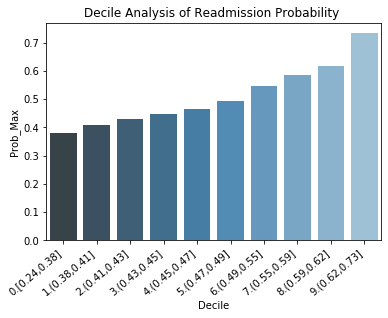

In [438]:
ax = sns.barplot(x=summary.index, y=summary.Prob_Max, data=summary, palette="Blues_d")
ax.set_title('Decile Analysis of Readmission Probability ')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

### Bootstrapping and SMOTE Synthetic Minority Over-Sampling Technique
- Upsampling minory class to create balanced dataset
- *conda install -c conda-forge imbalanced-learn*

In [463]:
from imblearn               import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

smote_ = SMOTE(random_state=42)

print('Resamplig Data with SMOTE')
X_res, y_res = smote_.fit_resample(X_train, y_train)

print('Original dataset shape %s'% y_train.shape[0])
print('Resampled dataset shape %s'% y_train.shape[0])

Resamplig Data with SMOTE
Original dataset shape 48538
Resampled dataset shape 48538


In [469]:


diab_logit_res = LogisticRegression(solver='liblinear') 

diab_logit_res.fit(X_train_res,y_train_res)

y_pred_res = diab_logit_res.predict(X_test)

print(classification_report(y_test, y_pred_res))


              precision    recall  f1-score   support

           0       0.91      0.75      0.82     18905
           1       0.11      0.30      0.16      1897

    accuracy                           0.71     20802
   macro avg       0.51      0.52      0.49     20802
weighted avg       0.84      0.71      0.76     20802



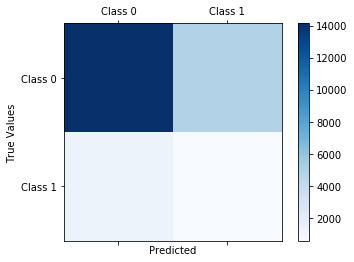

In [468]:
conf_matrix = confusion_matrix(y_test,y_pred_res )
labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax  = fig.add_subplot(111)
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)

fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.ylabel('True Values')
plt.xlabel('Predicted')
plt.show()

## Training on SMOTE and running prediction on non UPSAMPLED test data

In [471]:
print(X_test.shape)
print(X_test.columns)

(20802, 23)
Index(['time_in_hospital', 'num_medications', 'newage', 'class1_circulatory',
       'class1_digestive', 'class1_genitourinary', 'class1_injury',
       'class1_musculoskeletal', 'class1_neoplasms', 'class1_other',
       'class1_respiratory', 'class3_Caucasian', 'class3_Missing',
       'class3_Other', 'class6_other', 'class7_clin_ref', 'class7_hospital',
       'class7_other', 'class7_phys_ref', 'class7_snf', 'class8_>7',
       'class8_>8', 'class8_Norm'],
      dtype='object')


In [472]:
y_pred_non_smote = diab_logit_res.predict(X_test)

print('The accuracy score with SMOTE',accuracy_score(y_test, y_pred_non_smote))

The accuracy score with SMOTE 0.7066147485818671


In [473]:
conf_matrix_non_smote = confusion_matrix(y_test, y_pred_non_smote)
conf_matrix_non_smote

array([[14139,  4766],
       [ 1337,   560]])

In [474]:
print(classification_report(y_test, y_pred_non_smote))

              precision    recall  f1-score   support

           0       0.91      0.75      0.82     18905
           1       0.11      0.30      0.16      1897

    accuracy                           0.71     20802
   macro avg       0.51      0.52      0.49     20802
weighted avg       0.84      0.71      0.76     20802



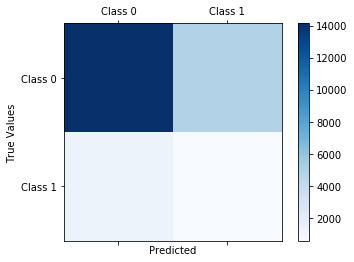

In [475]:
conf_matrix = confusion_matrix(y_test, y_pred_non_smote)
labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax  = fig.add_subplot(111)
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)

fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.ylabel('True Values')
plt.xlabel('Predicted')
plt.show()

## Model Evaluation

- **Accuracy**: Algorithms are designed to maximize accuracy and reduce error. 
    Not good for imbalanced dataset. 
    
    
- **Precision**: the number of true positives divided by all positive prediction.

    Precision = True Positive / True Positive + False Positive
    
    Precision is also called Positive Predictive Value. It is a measure of 
    classifier’s exactness. Low precision indicates a high number of false positives.
    
- **Confusion Matrix**: a table showing correct predictions and types of incorrect predictions.
-
- **Recall**: the number of true positives divided by the number of positive values in the test data. Recall is also called Sensitivity or the True Positive Rate. It is a measure of a classifier’s completeness. Low recall indicates a high number of false negatives.
-
- **F1 Score**: the weighted average of precision and recall.

In [114]:

print(classification_report(y_test_res, y_pred_res))

              precision    recall  f1-score   support

           0       0.72      0.75      0.74     19060
           1       0.73      0.71      0.72     18793

    accuracy                           0.73     37853
   macro avg       0.73      0.73      0.73     37853
weighted avg       0.73      0.73      0.73     37853



## Manual upsampling of Minority Class

In [267]:
diabdata3.readmitted.value_counts()

0    63087
1     6253
Name: readmitted, dtype: int64

In [480]:
# diabdata_majority = diabdata3[diabdata['readmitted']==0]
# diabdata_minority = diabdata3[diabdata['readmitted']==1]
 
# print('Majority: ',diabdata_majority.shape)
# print('Minority: ',diabdata_minority.shape)
# from sklearn.utils import resample

# # Upsample minority class
# diabdata_minority_upsampled = resample(diabdata_minority, 
#                                  replace=True,     # sample with replacement
#                                  n_samples=63087,    # to match majority class
#                                  random_state=42) # reproducible results
 
# # Combine majority class with upsampled minority class
# diabdata_upsampled = pd.concat([diabdata_majority, diabdata_minority_upsampled])
 
# # Display new class counts
# diabdata_upsampled.readmitted.value_counts()

Treshold [2 1 0]


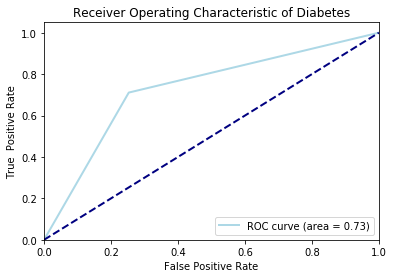

In [116]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# diab_logit.fit(X_train,y_train)
# y_pred = diab_logit.predict(X_test)

y_pred = diab_logit_res.predict(X_test_res)

# false posite rate, true porsitive rate
fpr, tpr, treshold = roc_curve(y_test_res, y_pred_res)
print('Treshold {}'.format(treshold))
roc_auc  = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='lightblue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True  Positive Rate')
plt.title('Receiver Operating Characteristic of Diabetes')
plt.legend(loc='lower right')
plt.show()

## Significance of Coefficients - Need to fix it for SMOTE sampled data columns names

In [117]:
import statsmodels.api as sm 

X_add_const_res = sm.add_constant(X_train)
sm_logit        = sm.Logit(y_train, X_train)
ans             = sm_logit.fit()
print(ans.summary())

/Users/karolylajko/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.307303
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             readmitted   No. Observations:                48538
Model:                          Logit   Df Residuals:                    48515
Method:                           MLE   Df Model:                           22
Date:                Thu, 19 Mar 2020   Pseudo R-squ.:                -0.01774
Time:                        22:40:06   Log-Likelihood:                -14916.
converged:                       True   LL-Null:                       -14656.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
time_in_hospital           0.0118      0.006      1.894      0.058      -0.000      

In [118]:
ans.summary().tables[1]

table = pd.DataFrame(ans.summary().tables[1].data[1:])
table.columns = ['name','coef','std err','t value','p value','2.5% confidence','97.5% confidence']
table = table.astype({'name':str,'coef':float,'std err':float, 't value':float, 'p value':float,'2.5% confidence':float, '97.5% confidence':float})
table[table['p value']<0.05]  # those coefficients with 0 lying outside their CIs


,name,coef,std err,t value,p value,2.5% confidence,97.5% confidence
1,num_medications,-0.0115,0.002,-5.184,0.000,-0.016,-0.007
2,newage,-0.0196,0.001,-24.437,0.000,-0.021,-0.018
3,class1_circulatory,-0.6316,0.051,-12.276,0.000,-0.732,-0.531
4,class1_digestive,-0.9201,0.069,-13.281,0.000,-1.056,-0.784
5,class1_genitourinary,-0.8417,0.084,-10.080,0.000,-1.005,-0.678
6,class1_injury,-0.6692,0.071,-9.447,0.000,-0.808,-0.530
7,class1_musculoskeletal,-1.0301,0.087,-11.817,0.000,-1.201,-0.859
8,class1_neoplasms,-0.8715,0.059,-14.874,0.000,-0.986,-0.757
9,class1_other,-0.7829,0.070,-11.115,0.000,-0.921,-0.645
10,class1_respiratory,-0.9959,0.063,-15.858,0.000,-1.119,-0.873


## Need to fix this plot

In [782]:

# plt.rcParams['figure.figsize'] = (10,5)
# y_min, y_max = -6.0,5.0

# table = pd.DataFrame(ans.summary().tables[1].data[1:])
# table.columns = ['name','coef','std err','t value','p value','2.5% confidence','97.5% confidence']
# table = table.astype({'name':str,'coef':float,'std err':float, 't value':float, 'p value':float, '2.5% confidence':float, '97.5% confidence':float})
# slope_table = table[['name', 'coef', '2.5% confidence', '97.5% confidence']].iloc[1:]
# slope_table.name = table.name


# slope_table['y_min'] = slope_table['2.5% confidence'].map(lambda t:(t-y_min)/(y_max-y_min))
# slope_table['y_max'] = slope_table['97.5% confidence'].map(lambda t:(t-y_min)/(y_max-y_min))
# x = range(1,22)
# plt.scatter(x, slope_table['coef'], label='slope', c='b')
# plt.axhline(0,linestyle='--', c='r')

# for i in x:
#     plt.axvline(i, ymin=slope_table['y_min'][i], ymax=slope_table['y_max'][i], marker='+', alpha=0.3)
# plt.xticks(x,slope_table.name,rotation='vertical')
# plt.ylim((y_min, y_max))
# plt.title('slopes and their CIs')
# plt.legend(loc=4)